**Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Neccesary Imports**

# New Section

In [2]:
!pip install -q torchvision

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import argparse
import copy

**Unzip file (RUN ONCE)**

In [3]:
# !unzip /content/drive/MyDrive/prime_data/Prime_FULL.zip -d /content/drive/MyDrive/prime_data/prime_dataset


In [ ]:
!unzip "/content/drive/MyDrive/prime_data/Prime_FULL.zip" -d "/content"

In [5]:
!cp "/content/drive/MyDrive/prime_data/df_prime_train.csv" -d "/content/"
!cp "/content/drive/MyDrive/prime_data/df_prime_test.csv" -d "/content/"



**Dataloader**

In [6]:
from skimage import exposure
from skimage.filters import median
from skimage.color import rgb2gray
from PIL import ImageOps



#Labels for Severity

LABELS_Severity = {35: 0,
                   43: 0,
                   47: 1,
                   53: 1,
                   61: 2,
                   65: 2,
                   71: 2,
                   85: 2}


mean = (.1706)
std = (.2112)
normalize = transforms.Normalize(mean=mean, std=std)

transform = transforms.Compose([
    transforms.Resize(size=(150,150)),
    transforms.ToTensor(),
    normalize,
])
    
class OCTDataset(Dataset):
    def __init__(self, args, subset='train', transform=None,):
        if subset == 'train':
            self.annot = pd.read_csv(args.annot_train_prime)
        elif subset == 'test':
            self.annot = pd.read_csv(args.annot_test_prime)
            
        self.annot['Severity_Label'] = [LABELS_Severity[drss] for drss in copy.deepcopy(self.annot['DRSS'].values)] 
        # print(self.annot)
        self.root = os.path.expanduser(args.data_root)
        self.transform = transform
        # self.subset = subset
        self.nb_classes=len(np.unique(list(LABELS_Severity.values())))
        self.path_list = self.annot['File_Path'].values
        self._labels = self.annot['Severity_Label'].values
        assert len(self.path_list) == len(self._labels)
        # idx_each_class = [[] for i in range(self.nb_classes)]

    def __getitem__(self, index):
        img, target = Image.open(self.root+self.path_list[index]).convert("L"), self._labels[index]

        img = transforms.Grayscale()(img)
        img = transforms.CenterCrop(size=(300, 300))(img)
        # # Apply contrast enhancement
        # img = ImageOps.equalize(img)

        if self.transform is not None:
            img = self.transform(img)
        return img, target


    def __len__(self):
        return len(self._labels)         

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--annot_train_prime', type = str, default = '/content/df_prime_train.csv')
    parser.add_argument('--annot_test_prime', type = str, default = '/content/df_prime_test.csv')
    parser.add_argument('--data_root', type = str, default = '/content/')
    parser.add_argument('-f') #For ipynb support
    return parser.parse_args()



if __name__ == '__main__':
    args = parse_args()
    trainset = OCTDataset(args, 'train', transform=transform)
    testset = OCTDataset(args, 'test', transform=transform)
    # print(args)
    print("Train Set Array Size:", trainset[1][0].shape)
    print("Size of trainset: " + str(len(trainset)) + "\nSize of testset:", len(testset))


Train Set Array Size: torch.Size([1, 150, 150])
Size of trainset: 24252
Size of testset: 7987


              precision    recall  f1-score   support

           0       0.37      0.38      0.38      2548
           1       0.53      0.55      0.54      3920
           2       0.24      0.19      0.21      1519

    accuracy                           0.43      7987
   macro avg       0.38      0.38      0.38      7987
weighted avg       0.42      0.43      0.43      7987

Balanced accuracy score: 0.3764601374048379


<ipython-input-8-652675fc040c>:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', len(unique_labels))


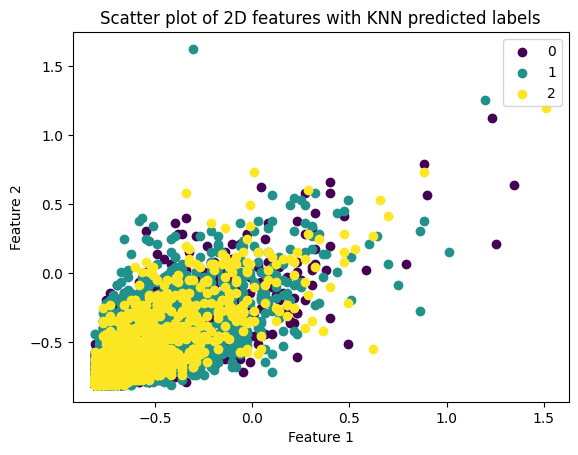

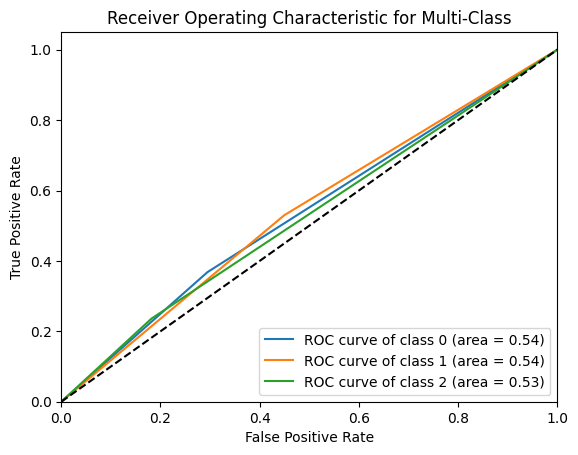

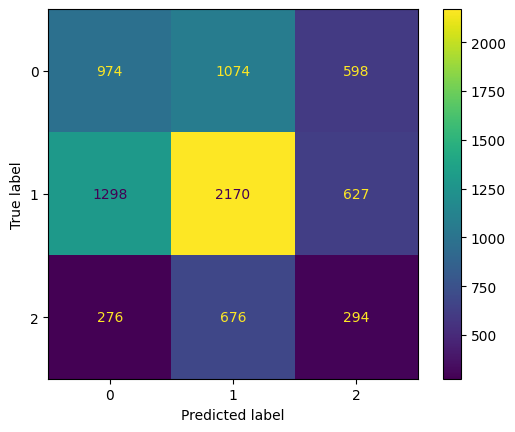

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import pickle
import matplotlib.pyplot as plt

def extract_features(dataset):
    features = []
    labels = []
    for img, label in dataset:
        img = img.numpy().reshape(-1)
        features.append(img)
        labels.append(label)
    return features, labels

def train_and_predict_knn(train_features, train_labels, test_features, n_neighbors):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(train_features, train_labels)
    return knn.predict(test_features)

train_features, train_labels = extract_features(trainset)
test_features, test_labels = extract_features(testset)
predicted_labels = train_and_predict_knn(train_features, train_labels, test_features, n_neighbors=7)

print(classification_report(test_labels, predicted_labels))
balanced_accuracy = balanced_accuracy_score(test_labels, predicted_labels)

print("Balanced accuracy score:", balanced_accuracy)
filename = 'knn3.sav'
pickle.dump(predicted_labels, open(filename, 'wb'))

import numpy as np

def plot_scatter_2d(features, labels, title='Scatter plot of 2D features'):
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('viridis', len(unique_labels))
    
    for i, label in enumerate(unique_labels):
        idx = np.where(labels == label)
        plt.scatter(features[idx, 0], features[idx, 1], color=colors(i), label=label)
    
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

test_features_np = np.array(test_features)

plot_scatter_2d(test_features_np, predicted_labels, title='Scatter plot of 2D features with KNN')
import pandas as pd

results_df = pd.DataFrame({'Predicted Labels': predicted_labels, 'Test Labels': test_labels})

results_df.to_csv('results.csv', index=False)
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

def read_labels_from_csv(filename):
    with open('results.csv', 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader) 
        
        actual_labels = []
        predicted_labels = []
        
        for row in csv_reader:
            test_labels.append(float(row[0]))
            predicted_labels.append(float(row[1]))
    
    return np.array(test_labels), np.array(predicted_labels)
def plot_roc_curve(test_labels, predicted_labels):
    fpr, tpr, _ = metrics.roc_curve(test_labels, predicted_labels)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(test_labels, predicted_labels):
    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
    disp.plot()
    plt.show()
def read_labels_from_csv(filename):
    with open(filename, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader) 
        
        test_labels = []
        predicted_labels = []
        
        for row in csv_reader:
            test_labels.append(float(row[0]))
            predicted_labels.append(float(row[1]))
    
    return np.array(test_labels), np.array(predicted_labels)
def plot_multiclass_roc_curve(test_labels, predicted_labels, n_classes):
    test_labels_binarized = label_binarize(test_labels, classes=np.arange(n_classes))
    predicted_labels_binarized = label_binarize(predicted_labels, classes=np.arange(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_labels_binarized[:, i], predicted_labels_binarized[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('Receiver Operating Characteristic for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()

test_labels1, predicted_labels1 = read_labels_from_csv('results.csv')

n_classes = len(np.unique(test_labels1))
plot_multiclass_roc_curve(test_labels1, predicted_labels1, n_classes)
plot_confusion_matrix(test_labels1, predicted_labels1)

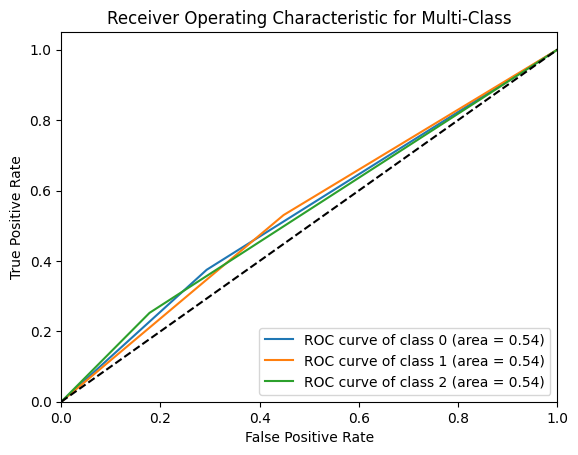

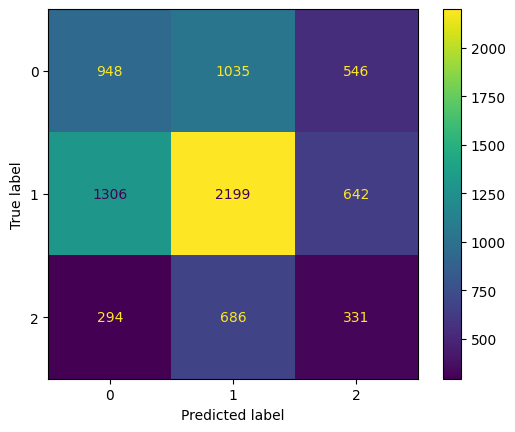

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
import pickle

def extract_features(dataset):
    features = []
    labels = []
    for img, label in dataset:
        img = img.numpy().reshape(-1) 
        features.append(img)
        labels.append(label)
    return features, labels
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score


trainset = OCTDataset(args, 'train', transform=transform)
testset = OCTDataset(args, 'test', transform=transform)
X_train, y_train = extract_features(trainset)
X_test, y_test = extract_features(testset)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print("Balanced accuracy score:", balanced_accuracy)
model_filename = f"random_forest_model_{200}_estimators.pkl"
with open(model_filename, 'wb') as file:
  pickle.dump(clf, file)

              precision    recall  f1-score   support

           0       0.24      0.11      0.15      2548
           1       0.54      0.84      0.66      3920
           2       0.26      0.12      0.16      1519

    accuracy                           0.47      7987
   macro avg       0.35      0.36      0.33      7987
weighted avg       0.39      0.47      0.41      7987

Balanced accuracy score: 0.3593073209432656


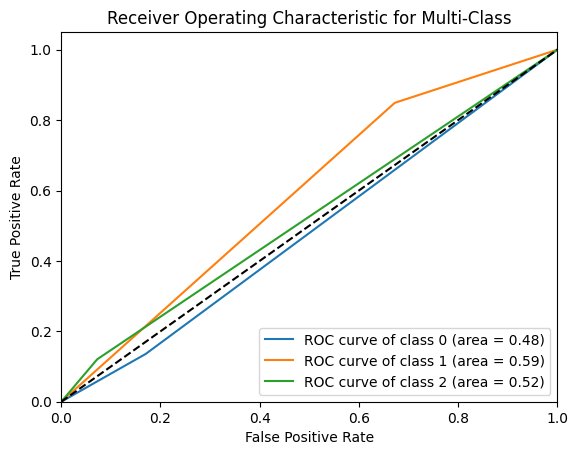

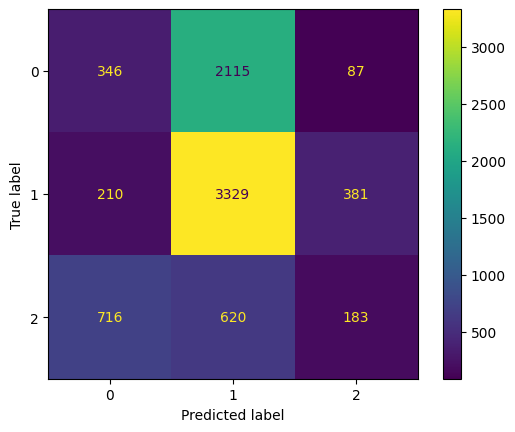

In [10]:
n_classes = len(np.unique(y_test))

plot_multiclass_roc_curve(y_test, y_pred, n_classes)
plot_confusion_matrix(y_test, y_pred)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

def plot_random_forest_trees(clf, num_trees_to_plot=3):
    """
    Plots a specified number of decision trees from a Random Forest classifier.

    Parameters:
    clf (RandomForestClassifier): A trained Random Forest classifier.
    num_trees_to_plot (int): The number of trees to plot. Default is 3.
    """
    total_trees = len(clf.estimators_)

    num_trees_to_plot = min(total_trees, num_trees_to_plot)

    for i in range(num_trees_to_plot):
        plt.figure(figsize=(20, 10))
        plot_tree(clf.estimators_[i], filled=True, rounded=True, proportion=True, fontsize=12)
        plt.title(f"Decision Tree {i + 1}")
        plt.show()


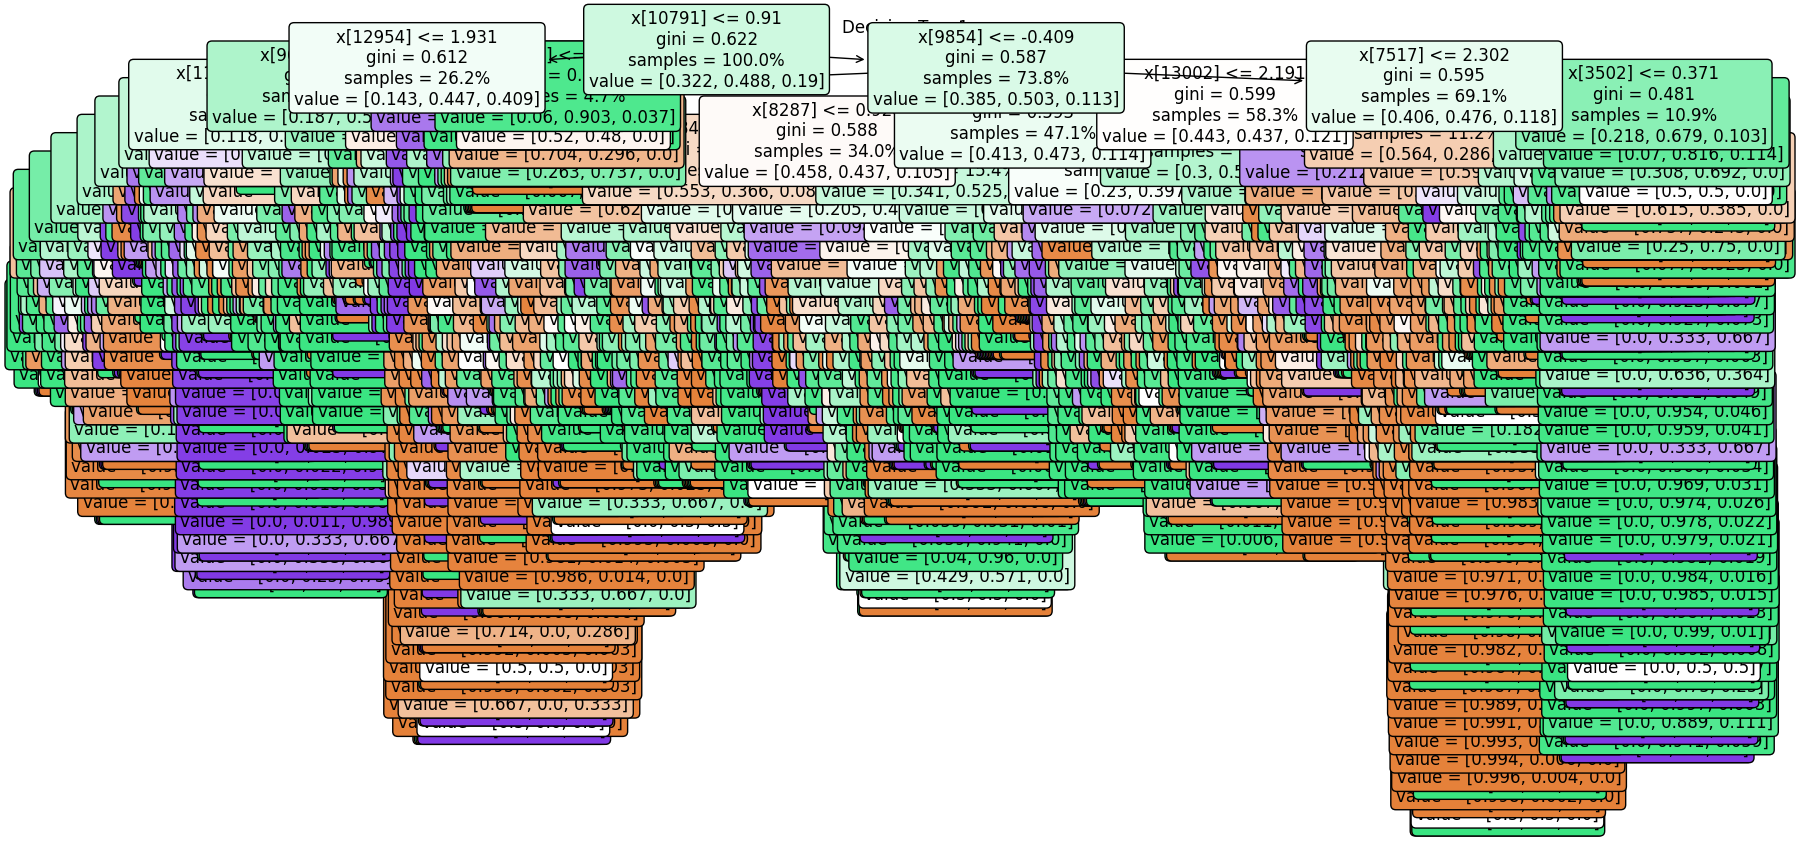

In [ ]:
plot_random_forest_trees(clf, num_trees_to_plot=1)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc = nn.Linear(32 * 6 * 6, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.adaptive_pool(x)
        x = x.view(-1, 32 * 6 * 6)
        x = self.fc(x)
        return x


num_epochs = 10
batch_size = 64
learning_rate = 0.001

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(trainset.nb_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    train_losses.append(running_loss / len(trainset))
    train_accuracies.append(running_corrects.double().item() / len(trainset))

    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    val_losses.append(running_loss / len(testset))
    val_accuracies.append(running_corrects.double().item() / len(testset))

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch 1/10, Train Loss: 0.9347, Train Acc: 0.5355, Val Loss: 1.0139, Val Acc: 0.5013
Epoch 2/10, Train Loss: 0.8468, Train Acc: 0.5908, Val Loss: 1.1655, Val Acc: 0.4775
Epoch 3/10, Train Loss: 0.8009, Train Acc: 0.6217, Val Loss: 1.2802, Val Acc: 0.4731
Epoch 4/10, Train Loss: 0.7769, Train Acc: 0.6358, Val Loss: 1.3174, Val Acc: 0.3934


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()